## This notebook focuses on two main objectives:

### 1. Accelerating Decision Making: Building a new feature to enhance artist recommendation.
### 2. Impact of NLP Entity Resolution: Demonstrating improvements in recommendations through named entity resolution for semantically-equivalent names.

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = f"{os.getcwd()}/data"

In [3]:
df = pd.read_csv(f"{data_dir}/spotify_dataset.csv",
                    skiprows=1,
                    names=['user_id', 'artistname', 'trackname', 'playlistname'],
                    on_bad_lines='skip')
df = df.sample(n=50000, random_state=42)
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 7578551 to 11943414
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       50000 non-null  object
 1   artistname    49859 non-null  object
 2   trackname     50000 non-null  object
 3   playlistname  49996 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


,user_id,artistname,trackname,playlistname
7578551,5c2b840d66d02ac7aa6a069eddd17f48,Spice Girls,Wannabe - Radio Edit,Lol HiGh Sk00l MeMorIeZ
911963,6da651f45aac18e5da52433aa3c38947,Flying Lotus,Descent Into Madness (feat. Thundercat),Best of 2014
8049506,20350023c94899ce25cd1a86ea385853,Kristin Hersh,Your Ghost,Ladies. All the ladies.
11247838,f9809d1afbab1b0aaa0c2f678a90752a,Rotary Connection,This Town,To listen to
6160700,db9646b77f3a677040b9140489da16f1,Bastille,Pompeii,Starred


In [4]:
df.describe()

,user_id,artistname,trackname,playlistname
count,50000,49859,50000,49996
unique,10104,17292,40212,23673
top,4398de6902abde3351347b048fcdc287,Coldplay,Intro,Starred
freq,1085,132,24,5221


In [5]:
# null values in dataframe
df.isnull().sum()

user_id           0
artistname      141
trackname         0
playlistname      4
dtype: int64

In [6]:
df[df['artistname'].isnull()]

,user_id,artistname,trackname,playlistname
10582452,9b0cb216778138cc481d17dee58a0319,NaN,avicii vs nicky romero - i could be the one (n...,Bautizo
10366650,93000d9cad22c61869db84fb96c8b5c9,NaN,Animal Crossing New Leaf - 12 PM (Extended),Animal Crossing
8186225,c8e0b3f55f4ecd3c0c7947a18e7472d8,NaN,16 - Joni Mitchell - Both Sides Now - www.torr...,MMM
3642727,74bc80e9a16ccd15a85f8d4d871000cf,NaN,Gee - SNSD,Osu!
8516423,67bb38768667210fe57b985c96f5fa4c,NaN,Ben Pearce - What I Might Do (Kilter Remix),1 wintah starred 14'
...,...,...,...,...
11928079,f36f93df429cd1dfa23cdf66b7b005c2,NaN,L'Empordà - Sopa De Cabra,Roa 2009
2723934,3f27634a1b38377b8d7f806f653dccbe,NaN,chikita violenta-loud(3).mp3,Musica
9476851,7ffae624f8f096dd429b1f7e78efb32b,NaN,Manuel Carrasco & Pastora Soler - Esta vez qui...,O.T ESPAÑOL
3707206,acb6836b10dd81dd551f18daa9aa754a,NaN,03 Do You Want It All,Ferran Music.


In [7]:
# drop nulls
df.dropna(inplace=True)

In [8]:
# duplicates
df[df.duplicated()]

,user_id,artistname,trackname,playlistname


## Exploratory Data Analysis

#### This dataset doesn't provide repeat of track/s, but merely tracks that have been played, and metadata like playlist and artistname the track belongs to! 
### Opportunity to learn more about user-artist preference. 

In [9]:
# artist frequently played by user
df.groupby(['user_id', 'artistname'], as_index=False
          )['trackname'].count().sort_values(by=['trackname'], ascending=False)

,user_id,artistname,trackname
6888,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,20
336,014e695cc6df96011b90a5beb3206012,Ilaiyaraaja,12
11704,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,12
45896,fa849dabeb14a2800ad5130907fc5018,Frank Sinatra,12
2762,106036f1fc9e3be1f674fb591765fb85,Grateful Dead,11
...,...,...,...
15954,54f4e5f88aca1f327bdbc73a5128c5f8,Dance DJ & Company,1
15955,54f4e5f88aca1f327bdbc73a5128c5f8,Modern Talking,1
15956,54f4e5f88aca1f327bdbc73a5128c5f8,Timber N Stone,1
15957,54f4e5f88aca1f327bdbc73a5128c5f8,Wham!,1


In [10]:
# track making into different playlist
df.groupby(['artistname', "trackname"], as_index=False
          )['playlistname'].nunique().sort_values(by=['playlistname'], ascending=False)

,artistname,trackname,playlistname
16534,Imagine Dragons,Radioactive,12
23361,Macklemore & Ryan Lewis,Can't Hold Us - feat. Ray Dalton,12
3320,Bastille,Pompeii,12
22448,Lorde,Royals,12
37947,The Killers,Mr. Brightside,11
...,...,...,...
15322,Half Man Half Biscuit,It's Clichéd To Be Cynical At Christmas,1
15324,Half Moon Run,Full Circle,1
15326,Halfbluud,Bully,1
15327,Hallal Music,Great Light of the World,1


In [11]:
# count of artist by playlist
df.groupby(['playlistname'], as_index=False
          )['artistname'].nunique().sort_values(by=['artistname'], ascending=False)

,playlistname,artistname
16895,Starred,3203
10631,Liked from Radio,602
6634,Favoritas de la radio,120
621,2013,96
697,2014,95
...,...,...
8980,J 5,1
8979,J - Pop,1
8978,J - French rap,1
8977,J - Favoritter,1


## Preprocessing artist name 

### text normalization

In [12]:
import re
# Function to normalize text
def normalize(text):
    text = text.lower() 
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r"[.'’]", '', text)  # Remove punctuation
    text = re.sub(r'^(the|a)\s+', '', text) # Remove the, a from start of the text
    return text

# Normalize all artist names
df['normalized_artistname'] = df['artistname'].apply(normalize)
df

,user_id,artistname,trackname,playlistname,normalized_artistname
7578551,5c2b840d66d02ac7aa6a069eddd17f48,Spice Girls,Wannabe - Radio Edit,Lol HiGh Sk00l MeMorIeZ,spice girls
911963,6da651f45aac18e5da52433aa3c38947,Flying Lotus,Descent Into Madness (feat. Thundercat),Best of 2014,flying lotus
8049506,20350023c94899ce25cd1a86ea385853,Kristin Hersh,Your Ghost,Ladies. All the ladies.,kristin hersh
11247838,f9809d1afbab1b0aaa0c2f678a90752a,Rotary Connection,This Town,To listen to,rotary connection
6160700,db9646b77f3a677040b9140489da16f1,Bastille,Pompeii,Starred,bastille
...,...,...,...,...,...
885721,544a5a791fc0a589f3789cd3833f5141,Amon Amarth,Where is Your God?,Mörs,amon amarth
7249281,9c6dc5b8e9c69c7b47cc53719b06d072,Tom Petty And The Heartbreakers,Refugee - Alt. Take,Album Rock Collxn - ALL of and Only the Best A...,tom petty and the heartbreakers
4017382,4d8f6c0a7f6377d1441f80451b6d626e,Karp,See You At Lakefair,FAVES ALL TIMES,karp
3217243,0ba964f15ee83976e666a22f0962bb54,Gary Clark Jr.,Bright Lights,2013's,gary clark jr


### Named Entity Resolution (NER) for semantically-equivalent names 

In [13]:
import difflib
def cleanup_dict(equivalent_names):
    new_equivalent_names = {}
    repeatative_names = []
    for k, v in equivalent_names.items():
        if k in repeatative_names:
            continue
        new_equivalent_names[k] = v
        repeatative_names.extend(v)
    return new_equivalent_names

def find_equivalent_names(list_artists):
    equivalent_names = {}
    for artist in list_artists:
        matches = difflib.get_close_matches(artist, list_artists, 
                                            n=5, cutoff=0.7
                                           ) #manage cutoff to get closest match based on requirement
        if len(matches) > 1:
            equivalent_names[artist] = matches
    return equivalent_names

equivalent_artist_names = cleanup_dict(
                            find_equivalent_names([str(n) for n in df['normalized_artistname'].unique()])
                        )

# print first 30 items from dictionary
i = 0
for k, v in equivalent_artist_names.items():
    print(k, v)
    i += 1
    if i == 30:
        break

spice girls ['spice girls', 'us girls', 'cheap girls', 'piney gir']
kristin hersh ['kristin hersh', 'kristin chenoweth']
rotary connection ['rotary connection', 't-connection', 'beat connection', 'deeper connection']
bastille ['bastille', 'braille', 'stills', 'billie', 'ballet']
joni mitchell ['joni mitchell', 'anais mitchell', 'lisa mitchell']
skillet ['skillet', 'skrillex', 'stilett', 'spiller', 'killers']
awolnation ['awolnation', 'animation']
since october ['since october', 'spin doctors', 'easy october', 'blue october']
linkin park ['linkin park', 'linkin park & jay-z', 'clinton sparks']
scar symmetry ['scar symmetry', 'symmetry']
blur ['blur', 'blu', 'blue']
16volt ['16volt', '16 volt']
crystal castles ['crystal castles', 'crystal waters', 'crystal stilts', 'crystal fighters']
faithless ['faithless', 'faith evans']
hives ['hives', 'givers']
david byrne & st vincent ['david byrne & st vincent', 'bon iver & st vincent']
andrew bird ['andrew bird', 'andrew ripp', 'andrew gold', 'new

## This self-identified list of semantically-equivalent artist names is intended for merging into single named entities. 

## With input from subject matter experts like content editors, the list can become more precise and accurate, enhancing model performance and reliability

In [27]:
# Identified artistnames that are semantically equivalent to be merged into a single named entity.
# With expert's knowledge we can create an accurate and 
semantically_equivalent_artistnames = {'16 volt':'16volt',
 '30 seconds to mars':'thirty seconds to mars',
 'b dylan': 'bob dylan',
 'dave matthews band':'dave matthews',
 'bjork': 'björk',
 'jay-z': 'jay z',
 'paul mccartney & wings':'paul mccartney',
  'original motion picture soundtrack':'motion city soundtrack',
 'macklemore & ryan lewis ft mary lambert': 'macklemore & ryan lewis',
 'imogen heap':'imagen heap',
 'pat metheny group':'pat metheny',
 'guns and roses':'guns n roses', 
 'belle & sebastian':'belle and sebastian',
 'sylvan':'sylvan esso',
 'william fitzsimmons & michael flynn':'william fitzsimmons',
 'drumsound & bassline smith': 'drumsound & bassline',
 'oscar de leon' : 'oscar dleón',
 'london symphony orchestra': 'london philharmonic orchestra',
  'relaxing piano music': 'relaxing piano music consort', 
 'florence + the machine': 'florence and the machine',
 'hans zimmer & james newton howard': 'james newton howard',
 'led zepagain': 'led zeppelin',
 'coheed & cambria': 'coheed and cambria',
 'beyonce ft jay z' : 'beyonce',
 'beyonce feat kanye west' : 'beyonce',
 'simon & garfunkel': 'simon and garfunkel', 
 'oscar peterson trio': 'oscar peterson',
 'dave brubeck':'dave brubeck quartet',
 'rocío dúrcal': 'rocio durcal',  
 'joaquin sabina':'joaquín sabina',
 'ray barretto': 'ray barreto',
 'kenny garrett quintet': 'kenny garrett',
 'elvis costello and the brodsky quartet' : 'elvis costello' ,
 'elvis costello & the imposters' : 'elvis costello',
 'elvis costello & the attractions' : 'elvis costello' ,
 'various artists - abba tribute': 'various artists - the eagles tribute',
}

In [28]:
# Replace artistname to it's semantically equivalent. Reducing noise.
df['semantical_equivalent_normalized_artistname'] = df['normalized_artistname'].apply(
    lambda x: semantically_equivalent_artistnames[x] if x in semantically_equivalent_artistnames else x)

# print
df[df['semantical_equivalent_normalized_artistname'].isin(semantically_equivalent_artistnames.values())
  ].groupby(['semantical_equivalent_normalized_artistname','normalized_artistname']).count().head(20)

user_id  \
semantical_equivalent_normalized_artistname normalized_artistname                 
16volt                                      16 volt                           1   
                                            16volt                            1   
belle and sebastian                         belle & sebastian                37   
                                            belle and sebastian               3   
beyonce                                     beyonce                           3   
                                            beyonce feat kanye west           1   
                                            beyonce ft jay z                  1   
björk                                       bjork                             1   
                                            björk                            34   
bob dylan                                   b dylan                           1   
                                            bob dylan                        92   
coheed and cambria                          coheed & cambria                  2   
                                            coheed and cambria               18   
dave brubeck quartet                        dave brubeck                      8   
                                            dave brubeck quartet              7   
dave matthews                               dave matthews                     8   
                                            dave matthews band               53   
drumsound & bassline                        drumsound & bassline              1   
                                            drumsound & bassline smith        1   
elvis costello                              elvis costello                   14   

                                                                        artistname  \
semantical_equivalent_normalized_artistname normalized_artistname                    
16volt                                      16 volt                              1   
                                            16volt                               1   
belle and sebastian                         belle & sebastian                   37   
                                            belle and sebastian                  3   
beyonce                                     beyonce                              3   
                                            beyonce feat kanye west              1   
                                            beyonce ft jay z                     1   
björk                                       bjork                                1   
                                            björk                               34   
bob dylan                                   b dylan                              1   
                                            bob dylan                           92   
coheed and cambria                          coheed & cambria                     2   
                                            coheed and cambria                  18   
dave brubeck quartet                        dave brubeck                         8   
                                            dave brubeck quartet                 7   
dave matthews                               dave matthews                        8   
                                            dave matthews band                  53   
drumsound & bassline                        drumsound & bassline                 1   
                                            drumsound & bassline smith           1   
elvis costello                              elvis costello                      14   

                                                                        trackname  \
semantical_equivalent_normalized_artistname normalized_artistname                   
16volt                                      16 volt                             1   
                                            16volt                              1   
belle and se

In [29]:
# get the counts
df_artistnames_semantically_equ = df[df['semantical_equivalent_normalized_artistname'].isin(semantically_equivalent_artistnames.values())
  ].groupby(['semantical_equivalent_normalized_artistname','normalized_artistname']).count().reset_index()

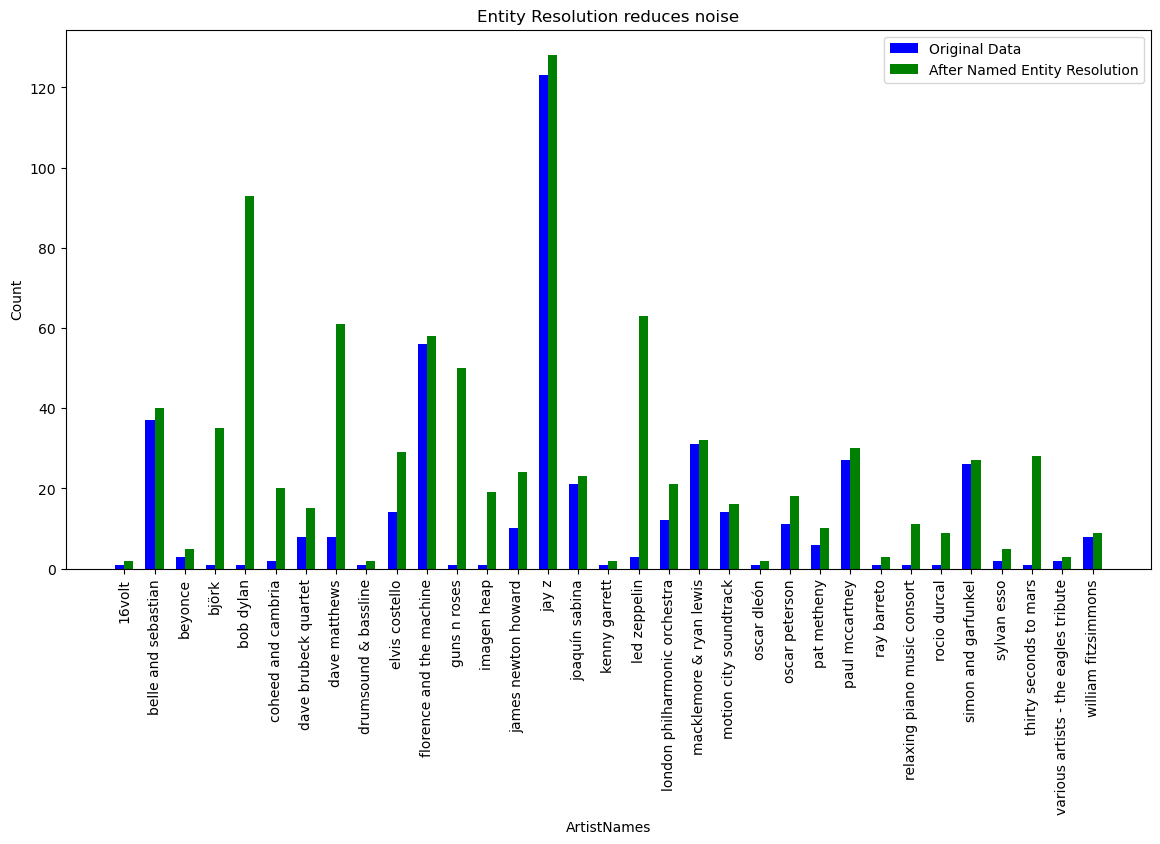

In [30]:
# entity list identified as semantically equivalent
artistname_semtanically_equi = list(df_artistnames_semantically_equ.groupby('semantical_equivalent_normalized_artistname'
                                                                           )['normalized_artistname'].first().reset_index()['normalized_artistname'])
artistname_entity = list(df_artistnames_semantically_equ['semantical_equivalent_normalized_artistname'].unique())



# Count the occurrences of each entity before and after NER
original_counts = df['normalized_artistname'][df['normalized_artistname'].isin(artistname_semtanically_equi)
                                ].value_counts().reindex(artistname_semtanically_equi)

after_ner_counts = df['semantical_equivalent_normalized_artistname'][df['semantical_equivalent_normalized_artistname'].isin(artistname_entity)
                                ].value_counts().reindex(artistname_entity)



r = np.arange(len(artistname_entity)) 
width = 0.3

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(14, 7))
plt.bar(r , original_counts.tolist(), color='b', width = width, label='Original Data')
plt.bar(r + width, after_ner_counts.tolist(), color='g', width = width, label='After Named Entity Resolution')

plt.xticks(r + width/2, artistname_entity, rotation=90)
plt.xlabel('ArtistNames')
plt.ylabel('Count')
plt.title('Entity Resolution reduces noise')
plt.legend() 
plt.show()

## User-Artist Interaction Matrix

In [31]:
# named entity resolution - user artist matrix 
user_artist_ner_matrix = df.groupby(['user_id', 'semantical_equivalent_normalized_artistname']
                               )['semantical_equivalent_normalized_artistname'].count().unstack().reset_index().fillna(0)
user_artist_ner_matrix.set_index('user_id', inplace=True)

# user artist matrix 
user_artist_matrix = df.groupby(['user_id', 'normalized_artistname']
                               )['normalized_artistname'].count().unstack().reset_index().fillna(0)
user_artist_matrix.set_index('user_id', inplace=True)                             

In [32]:
print(f"Applying Named Entity Resolution reducing dimensionality {len(user_artist_matrix.columns)}\
 to {len(user_artist_ner_matrix.columns)} ")

Applying Named Entity Resolution reducing dimensionality 17151 to 17115 


##### Techniques like K-means, DBScan will not yield meaningful result with sparse feature unless we further apply dimensionality reduction.
## User-based collaborative filtering

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

similar_users_dict = {}

def user_cosine_similarity(user_artist_matrix):
    
    # Compute the cosine similarity between users
    user_similarity = cosine_similarity(user_artist_matrix)
    # Create a DataFrame for user similarity
    df_user_similarity = pd.DataFrame(user_similarity, index=user_artist_matrix.index, columns=user_artist_matrix.index)
    return df_user_similarity

def recommend_top_artists(user_id, df_user_similarity, user_artist_matrix, similar_users = 5, top_artist = 10):
    def get_top_n_similar_users(user_id, n):
        list_similar_users = df_user_similarity[user_id].sort_values(ascending=False).head(n+1).index.tolist()
        if user_id in list_similar_users:
            list_similar_users.remove(user_id)
            
        return list_similar_users
    
    list_similar_users = get_top_n_similar_users(user_id, similar_users)
    artist_scores = pd.DataFrame(user_artist_matrix.loc[list_similar_users].mean(axis=0))
    artist_scores.index.name = 'artistname'
    top_artists = artist_scores[artist_scores[0]>0].reset_index().sort_values(by = [0, 'artistname'],ascending=False
                                                         )['artistname'].head(top_artist).tolist()
    return list_similar_users, top_artists


user_id = '0025022960e5f0d7d01af5d840014594'
matrix = user_artist_matrix
list_similar_users, top_artists = recommend_top_artists(user_id, user_cosine_similarity(matrix), matrix,
                                    similar_users = 5, top_artist = 3
                                   )
print(f"Top 10 artist recommendations for user {user_id}: {top_artists}")

Top 10 artist recommendations for user 0025022960e5f0d7d01af5d840014594: ['laura marling', 'nirvana', 'neonschwarz']


In [34]:
user_id = '5b82c20e6b45a79c382e80e96e04b956'
top_artist = 5
similar_users = 5

matrix = user_artist_matrix
list_similar_users, top_artists = recommend_top_artists(user_id, user_cosine_similarity(matrix), matrix,
                                    similar_users = similar_users, top_artist = top_artist
                                   )
print(f"Top {top_artist} artist recommendations for user {user_id} : \n {top_artists} \n")
print(f"Here are the {similar_users} similar users \n \t {sorted(list_similar_users)}")
for u in sorted(list_similar_users):
    sorted_artist = user_artist_matrix.loc[u].reset_index().sort_values(by = [f"{u}",'normalized_artistname'], ascending=False)
    list_artist = sorted_artist[sorted_artist[f"{u}"]>0].head(top_artist)['normalized_artistname'].tolist()
    print(f"\t Artist frequented by {u}: \n \
        {list_artist}")
# {user_artist_matrix.loc[u].sort_index().sort_values(ascending=False).head(top_artist)} the sorting is incorrect this way

    
print('\n')
print('---------------- Improved Recommendation with Entity Resolution ---------------------------------------------- \n')
matrix = user_artist_ner_matrix
list_similar_users_ner, top_artists_ner = recommend_top_artists(user_id, user_cosine_similarity(matrix), matrix,
                                    similar_users = similar_users, top_artist = top_artist
                                   )
print(f"Top {top_artist} NER artist recommendations for user {user_id} : \n {top_artists_ner} \n")
print(f"Here are the {similar_users} similar users \n \t {sorted(list_similar_users_ner)}")
for u in sorted(list_similar_users_ner):
    sorted_artist = user_artist_ner_matrix.loc[u].reset_index().sort_values(by = [f"{u}",'semantical_equivalent_normalized_artistname'], ascending=False)
    list_artist = sorted_artist[sorted_artist[f"{u}"]>0].head(top_artist)['semantical_equivalent_normalized_artistname'].tolist()
    print(f"\t Artist frequented by {u}: \n \
        {list_artist}")


Top 5 artist recommendations for user 5b82c20e6b45a79c382e80e96e04b956 : 
 ['converge', 'modest mouse', 'glitch mob', 'pretty lights', 'mastodon'] 

Here are the 5 similar users 
 	 ['1747883282275c1384f54c270e702226', '9cba77d99ca8d118f390e3ca59aca8be', 'ba4c6c7adb0a9996c5e5d724767c22ac', 'c17b6bfb3dac6f494719b77b9b08af15', 'f28174745b902099bc054eaf2f657e67']
	 Artist frequented by 1747883282275c1384f54c270e702226: 
         ['when saints go machine', 'siriusmo', 'röyksopp', 'raekwon', 'pvt']
	 Artist frequented by 9cba77d99ca8d118f390e3ca59aca8be: 
         ['youth lagoon', 'war on drugs', 'thee oh sees', 'supernumerario', 'standstill']
	 Artist frequented by ba4c6c7adb0a9996c5e5d724767c22ac: 
         ['mastodon', 'supermachiner', 'slipknot', 'slayer', 'radiovinil']
	 Artist frequented by c17b6bfb3dac6f494719b77b9b08af15: 
         ['tim mcgraw', 'scotty mccreery', 'lady gaga', 'kenny chesney', 'coheed & cambria']
	 Artist frequented by f28174745b902099bc054eaf2f657e67: 
         ['

### get top artist recommendation for all users

In [35]:
user_top_artists_recommendation = {}

df_user_cosine_similarity = user_cosine_similarity(user_artist_matrix)

df_user_ner_cosine_similarity = user_cosine_similarity(user_artist_ner_matrix)

similar_users = 5
top_artist = 3
for user_id in df.user_id:
    user_top_artists_recommendation[user_id] = []
    list_similar_users, top_artists = recommend_top_artists(user_id, df_user_cosine_similarity, user_artist_matrix,
                                    similar_users = similar_users, top_artist = top_artist 
                                   )
    user_top_artists_recommendation[user_id].append(top_artists)
    
    # ner 
    list_similar_users, top_ner_artists = recommend_top_artists(user_id, df_user_ner_cosine_similarity, user_artist_ner_matrix,
                                similar_users = similar_users, top_artist = top_artist 
                               )
    user_top_artists_recommendation[user_id].append(top_ner_artists)

In [36]:
df_top_artist_recommendation = pd.DataFrame.from_dict(user_top_artists_recommendation,orient='columns').transpose()
df_top_artist_recommendation.columns=['top artist recommendation','Improved - entity Resolution top artist recommendation']

df_top_artist_recommendation.head(50)

,top artist recommendation,Improved - entity Resolution top artist recommendation
5c2b840d66d02ac7aa6a069eddd17f48,"[backstreet boys, spice girls, sebastian ingro...","[backstreet boys, spice girls, sebastian ingro..."
6da651f45aac18e5da52433aa3c38947,"[aphex twin, tame impala, kendrick lamar]","[aphex twin, tame impala, kendrick lamar]"
20350023c94899ce25cd1a86ea385853,"[blonde redhead, wu-tang clan, new order]","[blonde redhead, wu-tang clan, new order]"
f9809d1afbab1b0aaa0c2f678a90752a,"[nine inch nails, morrissey]","[nine inch nails, morrissey]"
db9646b77f3a677040b9140489da16f1,[daft punk],[daft punk]
7ee6797934d627b54a72dda785b1ea85,"[dinosaur jr, temple of the dog, tamaryn]","[dinosaur jr, temple of the dog, tamaryn]"
5c4438bac13e50d6db5058ad0b0983da,"[kate bush, yeah yeah yeahs, norah jones]","[kate bush, yeah yeah yeahs, norah jones]"
705e46c3ff12a665e14ab67c497f18ac,"[linkin park, skillet, thousand foot krutch]","[linkin park, skillet, thousand foot krutch]"
ec4faa478b43b87aa990f5f2b7d0f414,[nine inch nails],[nine inch nails]
500e8b67136775d227d35a1bb37478aa,"[toro y moi, tv on the radio, tame impala]","[toro y moi, tv on the radio, tame impala]"


In [37]:
print('Total Users' , len(df_top_artist_recommendation.index))

per_users_artist_recom_impacted = round(len(
                                    np.where(
                                        (df_top_artist_recommendation['top artist recommendation'] != df_top_artist_recommendation['Improved - entity Resolution top artist recommendation'])
                                    )[0])*100/len(df_top_artist_recommendation.index),2)

print()
print('--------------------------------------------------------------------------- \n ')
print(f"\t {per_users_artist_recom_impacted}% user's recommendation improved with Entity Resolution")
print('\n---------------------------------------------------------------------------')

Total Users 10091

--------------------------------------------------------------------------- 
 
	 4.9% user's recommendation improved with Entity Resolution

---------------------------------------------------------------------------


# -------------------------------------------------------------------------------------

### Next steps or challenges:
#### - Limited data. Data Collection like 
    1. Content data 
        song metadata such as release year and duration
        attributes of songs such as tempo, key, loudness, modesuch as tempo, genre, mood
    
    2. User data
        interaction data: skips, likes, dislikes, shares, and playlist additions.
        search queries: search terms users use to find music.
##### - Working with larger volume of data. 
##### - Editorial input in artist name - Named Entity Resolution would further improve this feature thereby model's performance